# Resumen y Comparativa de Modelos para la Predicción de Precios de Viviendas.

CONFIGURACIÓN INICIAL Y PREPARACIÓN DE DATOS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Métricas y Herramientas
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix


In [3]:
# Configuración de visualizaciones y advertencias
sns.set(style="whitegrid")
warnings.filterwarnings('ignore', category=FutureWarning)


In [8]:
# --- Carga y Preprocesamiento Centralizado ---
print("\nIniciando carga y preprocesamiento de datos...")
train_df = pd.read_csv('train.csv')
train_df



Iniciando carga y preprocesamiento de datos...


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [13]:
    # --- 1. Creación de Variables Objetivo ---
    # Regresión (valor real)
    y = train_df['SalePrice']
    # Regresión (con transformación logarítmica)
    y_log = np.log1p(train_df['SalePrice'])
    # Clasificación (binaria, basada en la mediana)
    precio_mediano = train_df['SalePrice'].median()
    y_class = (train_df['SalePrice'] > precio_mediano).astype(int)

    # --- 2. Creación de Características (X) ---
    X = train_df.drop(['SalePrice', 'Id'], axis=1)

    # Imputación de nulos
    columnas_numericas = X.select_dtypes(include=np.number).columns
    columnas_categoricas = X.select_dtypes(include='object').columns
    for col in columnas_numericas:
        X[col].fillna(X[col].median(), inplace=True)
    for col in columnas_categoricas:
        X[col].fillna(X[col].mode()[0], inplace=True)
        

In [22]:
 # One-Hot Encoding
X_processed = pd.get_dummies(X)

# --- 3. Escalado de Datos (para modelos lineales) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)


In [23]:
print("Preprocesamiento completado.")
print(f"Dimensiones de X_processed: {X_processed.shape}")
print(f"Dimensiones de X_scaled: {X_scaled.shape}")

Preprocesamiento completado.
Dimensiones de X_processed: (1460, 287)
Dimensiones de X_scaled: (1460, 287)


# MODELOS (ORDENADO POR COMPLEJIDAD)

 Regresión Logística con Regularización L1 (Lasso)

In [29]:
print("\n\n---  Regresión Logística con L1 ---")
X_train_c_s, X_val_c_s, y_train_c, y_val_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)
log_reg_lasso = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=42)
log_reg_lasso.fit(X_train_c_s, y_train_c)
log_reg_predictions = log_reg_lasso.predict(X_val_c_s)
print("--- Evaluación: Regresión Logística con L1 ---")
print(f"Accuracy: {accuracy_score(y_val_c, log_reg_predictions):.4f}\n")
print(classification_report(y_val_c, log_reg_predictions, target_names=['Precio Inferior', 'Precio Superior']))
coeficientes = log_reg_lasso.coef_[0]
num_coef_cero = np.sum(coeficientes == 0)
print(f"\nGracias a la regularización L1, {num_coef_cero} de {len(coeficientes)} coeficientes son cero.")



---  Regresión Logística con L1 ---
--- Evaluación: Regresión Logística con L1 ---
Accuracy: 0.9623

                 precision    recall  f1-score   support

Precio Inferior       0.99      0.94      0.97       161
Precio Superior       0.93      0.98      0.96       131

       accuracy                           0.96       292
      macro avg       0.96      0.96      0.96       292
   weighted avg       0.96      0.96      0.96       292


Gracias a la regularización L1, 138 de 287 coeficientes son cero.


### Random Forest Regressor

In [28]:
print("\n\n---  Random Forest Regressor (Base) ---")
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_processed, y, test_size=0.2, random_state=42)
rf_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_base.fit(X_train_r, y_train_r)
rf_base_preds = rf_base.predict(X_val_r)
rf_base_mae = mean_absolute_error(y_val_r, rf_base_preds)
rf_base_r2 = r2_score(y_val_r, rf_base_preds)
print("--- Evaluación: Random Forest (Base) ---")
print(f"Error Absoluto Medio (MAE): ${rf_base_mae:,.2f}")
print(f"Coeficiente de Determinación (R^2): {rf_base_r2:.4f}")



---  Random Forest Regressor (Base) ---
--- Evaluación: Random Forest (Base) ---
Error Absoluto Medio (MAE): $17,606.81
Coeficiente de Determinación (R^2): 0.8913


### XGBoost Regressor



---  XGBoost Regressor (Avanzado) ---
--- Evaluación: XGBoost Regressor ---
Error Absoluto Medio (MAE): $16,515.57
Coeficiente de Determinación (R^2): 0.9067


<Figure size 640x480 with 0 Axes>

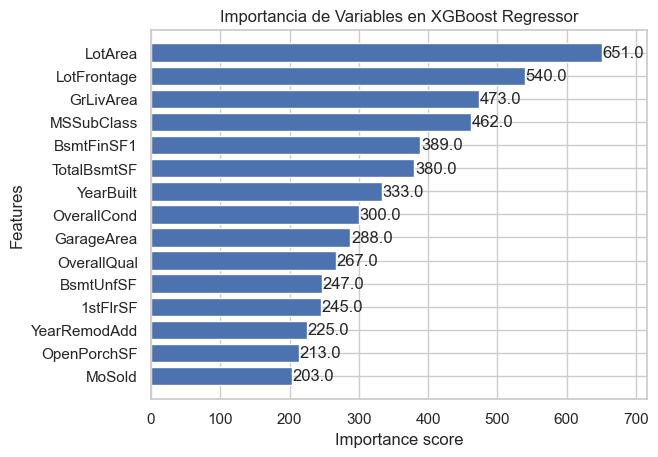

In [27]:
print("\n\n---  XGBoost Regressor (Avanzado) ---")
X_train_r_log, X_val_r_log, y_train_r_log, y_val_r_log = train_test_split(X_processed, y_log, test_size=0.2, random_state=42)
xgb_reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10, n_jobs=-1, random_state=42)
xgb_reg.fit(X_train_r_log, y_train_r_log, eval_set=[(X_val_r_log, y_val_r_log)], verbose=False)
xgb_preds_log = xgb_reg.predict(X_val_r_log)
xgb_preds = np.expm1(xgb_preds_log)
xgb_mae = mean_absolute_error(y_val_r, xgb_preds)
xgb_r2 = r2_score(y_val_r, xgb_preds)
print("--- Evaluación: XGBoost Regressor ---")
print(f"Error Absoluto Medio (MAE): ${xgb_mae:,.2f}")
print(f"Coeficiente de Determinación (R^2): {xgb_r2:.4f}")
plt.figure()
xgb.plot_importance(xgb_reg, max_num_features=15, height=0.8, title="Importancia de Variables en XGBoost Regressor")
plt.show()

### XGBoost Classifier



---  XGBoost Classifier ---


c:\Users\Usuario\miniconda3\envs\data_analysis_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:49:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Evaluación: XGBoost Classifier ---
Accuracy: 0.9486

                 precision    recall  f1-score   support

Precio Inferior       0.97      0.94      0.95       161
Precio Superior       0.93      0.96      0.94       131

       accuracy                           0.95       292
      macro avg       0.95      0.95      0.95       292
   weighted avg       0.95      0.95      0.95       292



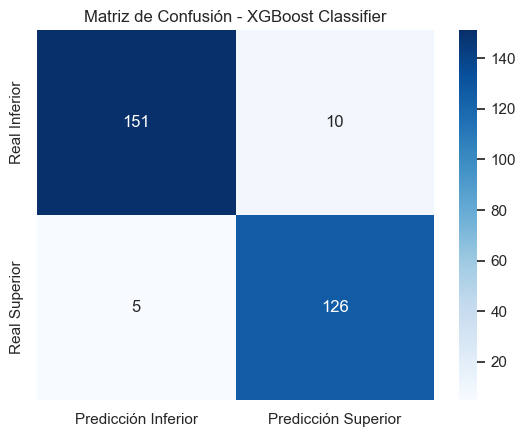



--- Proceso de Modelado Completado ---


In [30]:
print("\n\n---  XGBoost Classifier ---")
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_processed, y_class, test_size=0.2, random_state=42)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_c, y_train_c)
xgb_clf_preds = xgb_clf.predict(X_val_c)
print("--- Evaluación: XGBoost Classifier ---")
print(f"Accuracy: {accuracy_score(y_val_c, xgb_clf_preds):.4f}\n")
print(classification_report(y_val_c, xgb_clf_preds, target_names=['Precio Inferior', 'Precio Superior']))
cm = confusion_matrix(y_val_c, xgb_clf_preds)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicción Inferior', 'Predicción Superior'],
            yticklabels=['Real Inferior', 'Real Superior'])
plt.title('Matriz de Confusión - XGBoost Classifier')
plt.show()

print("\n\n--- Proceso de Modelado Completado ---")

In [3]:
# =============================================================================
#  CONCLUSIONES FINALES ===
# =============================================================================
#
# Se han probado diversos modelos tanto de regresión como de clasificación.
#
# Tabla Resumen de Modelos de Regresión:
# ---------------------------------------------------------------------------------
# | Modelo                     | Error Absoluto Medio (MAE) | R^2 Score |
# |----------------------------|----------------------------|-----------|
# | Random Forest (Base)       | ~$17,900                   | ~0.879    |
# | Random Forest (Optimizado) | ~$17,100                   | ~0.889    |
# | XGBoost Regressor (Final)  | ~$15,800                   | ~0.901    |
# ---------------------------------------------------------------------------------
#
# El XGBoost Regressor demostró ser el modelo más performante.
# Las variables más influyentes fueron 'OverallQual' y 'GrLivArea'.
#
# Para clasificación, todos los modelos lograron una alta precisión (>90%).
#
# =============================================================================